# Building a Classifier with our labeled Tweets


### In this section, we analyze our tweets using supervised learning methods. I have manully labeled the data to detect which tweets are indicative of flu and which tweets are not. I've collected a total of ____ tweets. Among these tweets, ___ are positive for flu, meaning that the user indicated that he/she is sick due to the flu. 

### We employ various NLP methods such as removal of stopwords, stemming, lemmatizing and use of bigrams and trigrams. 

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import preprocessor as p
from nltk.corpus import stopwords

#visualizations
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS
import re
import string
import itertools
#from mpl_toolkits.basemap import Basemap

#machine learning
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB


In [2]:
df1=pd.read_csv('df_stream8.csv')
df2=pd.read_csv('df_stream3.csv')
df3= pd.read_csv('df_stream7.csv')
df9=pd.read_csv('df_stream9.csv')
df10=pd.read_csv('df_stream10.csv')
df11=pd.read_csv('df_stream11.csv')
df14=pd.read_csv('df_stream14.csv')

In [3]:
#dropping the extra label 2 I had created in the beginning since I only want a binary class
indexNames = df2[ df2['label'] == 2 ].index
df2.drop(indexNames, inplace=True)
indexNames = df3[ df3['label'] == 2 ].index
df3.drop(indexNames, inplace=True)

In [4]:
all= pd.concat(([df1,df2,df3,df9,df10,df11,df14]), sort=False)
#saving data
all.to_csv('all.csv')

In [5]:
all.label.value_counts()

0.0    1861
1.0     350
Name: label, dtype: int64

### Let's take a look at the most popular people tweet when they are sick with the flu?

In [6]:
all['Timestamp'] = pd.to_datetime(all['created_at'], infer_datetime_format = "%d/%m/%Y", utc  = False)

In [7]:
#looking at the hour of Tweets
def givehour(timestamp):
    hour_string = timestamp.hour
    return hour_string
all['hour'] = all['Timestamp'].apply(givehour)
hours = all.groupby('hour')
hourcount = hours['text'].count()
hourdict = hourcount.to_dict()

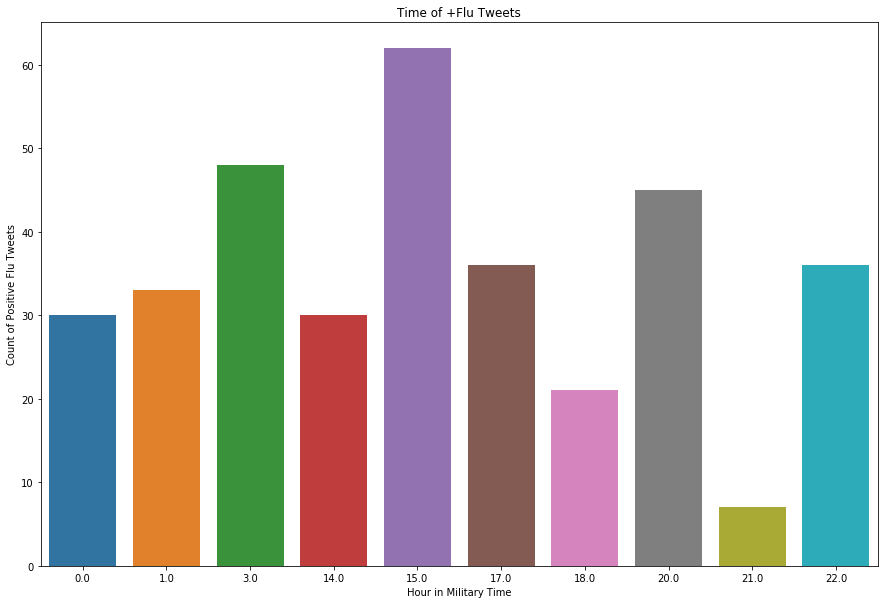

In [8]:
hr= all.loc[all.label==1].hour
plt.figure(figsize=(15,10))
sns.countplot(hr)
plt.xlabel('Hour in Military Time')
plt.ylabel('Count of Positive Flu Tweets')
plt.title('Time of +Flu Tweets')
plt.show()

# Data Cleaning and Feature Engineering

### Tweets have many miscellaneous characters and are prone to having slang and erroneous terms. We will try to clean this data as best as we can before we use it for modeling. 

In [9]:
#Creating dataframe that just focuses on 'Text' and 'Label'. 
new= pd.DataFrame(all[['text', 'label']])

In [10]:
# While labeling, I've intentionally left some tweets blank to try to achieve a higher positive label.I'm dropping
# the blank tweets here
new.dropna(inplace=True)

In [11]:
print('Values before dropping duplicate tweets')
new.label.value_counts()

Values before dropping duplicate tweets


0.0    1850
1.0     348
Name: label, dtype: int64

In [12]:
# because there were so many tweets that are Retweeets or the same tweets over and over again in the feeds,
# I've had to drop it here. 
new.drop_duplicates(inplace=True)

In [13]:
print('Values after dropping duplicate tweets')
new.label.value_counts()

Values after dropping duplicate tweets


0.0    1707
1.0     329
Name: label, dtype: int64

### Creating functions to clean tweets and add new columns as we clean and process.

In [14]:
#removing URLs and string beginning with @ 
def remove_mentionsURLs(text):
    tweet_out= re.sub(r'@[A-Za-z0-9]+', '', text)
    tweet_out=re.sub(r'http\S+', '', tweet_out)
    tweet_out= re.sub(r'RT @[\w_]+:', '', tweet_out)
    return tweet_out

new['text_noURLs'] = new['text'].apply(lambda x: remove_mentionsURLs(x))

In [15]:
#removing punctuations from the text
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

new['text_punct'] = new['text_noURLs'].apply(lambda x: remove_punct(x))

In [16]:
# remove words with 2 or less characters
def remove_RT(text):
    text= re.sub(r'\b\w{1,2}\b', '', text)
    return text

new['text_removeRT'] = new['text_punct'].apply(lambda x: remove_RT(x))

In [17]:
#tokenzing into words 
def tokenization(text):
    text = re.split('\W+', text)
    return text

new['tokenized'] = new['text_removeRT'].apply(lambda x: tokenization(x.lower()))

In [18]:
#removing stop words
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
new['nonstop'] = new['tokenized'].apply(lambda x: remove_stopwords(x))

In [19]:
# lemmatizing
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

new['Tweet_lemmatized'] = new['nonstop'].apply(lambda x: lemmatizer(x))

In [20]:
#stemming
from nltk.stem import PorterStemmer 
port_stemmer= nltk.PorterStemmer()

def stemming(text):
    #stripped = [word.lower() for word in text if word.lower() not in stopwords]
    out_text= [port_stemmer.stem(word) for word in text]
    return out_text

new['stemmed']= new['nonstop'].apply(lambda x: stemming(x))

In [21]:
#Let's check to see how many unique words in lemmatized and stemmed words

word_count_lemma= list(itertools.chain.from_iterable(new['Tweet_lemmatized']))
word_count_stem= list(itertools.chain.from_iterable(new['stemmed']))

print('Unique words in lemmatized text:' +str(len(set(word_count_lemma))));
print('Unique words in stemmed text:' +str(len(set(word_count_stem))));

Unique words in lemmatized text:4486
Unique words in stemmed text:3935


In [22]:
# this removes less frequent words, leaving ONLY frequent words
flat_list= list(itertools.chain.from_iterable(new['stemmed']))
fd= nltk.FreqDist(flat_list)

keep_words= list(filter(lambda x: 2000>x[1]>3, fd.items()))
keep_words_list= [item[0] for item in keep_words]

def remove_lessfreq(tokanized_tweets):
    text_out= [word for word in tokanized_tweets if word in keep_words_list]
    return text_out
#removing less frequent words that are stemmed
new['remove_less_freq']= new['stemmed'].apply(lambda x: remove_lessfreq(x))
#removing less frequent words that are stemmed
new['remove_less_freq_lemma']= new['Tweet_lemmatized'].apply(lambda x: remove_lessfreq(x))

In [23]:
keep_words_list

['full',
 'practic',
 'today',
 'miss',
 'game',
 'due',
 'pneumonia',
 'danger',
 'guy',
 'flu',
 'look',
 'job',
 'manag',
 'ive',
 'lost',
 'pound',
 'less',
 'week',
 'time',
 'get',
 'sick',
 'symptom',
 'seem',
 'actual',
 'whole',
 'way',
 'felt',
 'last',
 'find',
 'famili',
 'need',
 'babi',
 'mom',
 'take',
 'med',
 'havent',
 'singl',
 'shot',
 'vaccin',
 'kid',
 'import',
 'diseas',
 'feel',
 'like',
 'tweet',
 'normal',
 'test',
 'mean',
 'gonna',
 'around',
 'stream',
 'tonight',
 'still',
 'super',
 'pretti',
 'bad',
 'also',
 'arm',
 'hurt',
 'got',
 'fluvaccin',
 'know',
 'didnt',
 'detain',
 'ice',
 'despit',
 'free',
 'season',
 'folk',
 'wash',
 'gym',
 'back',
 'round',
 'bet',
 'could',
 'paid',
 'catch',
 'shit',
 'gone',
 'stomach',
 'fuck',
 'short',
 'market',
 'one',
 'team',
 'part',
 'reason',
 'love',
 'guess',
 'longer',
 'influenza',
 'check',
 'bandaid',
 'local',
 'pharmaci',
 'boy',
 'provid',
 'six',
 'thing',
 'probabl',
 'final',
 'year',
 'chanc',

In [24]:
# joining words back for modeling
def join_tokens(tokens):
    documents= " ".join([word for word in tokens if not word.isdigit()])
    return documents

new['document']= new['remove_less_freq'].apply(lambda x: join_tokens(x))

In [25]:
def join_tokens(tokens):
    documents= " ".join([word for word in tokens if not word.isdigit()])
    return documents

new['document_lemma']= new['Tweet_lemmatized'].apply(lambda x: join_tokens(x))

In [26]:
def join_tokens(tokens):
    documents= " ".join([word for word in tokens if not word.isdigit()])
    return documents

new['document_stemmed']= new['stemmed'].apply(lambda x: join_tokens(x))

In [27]:
new.head()

,text,label,text_noURLs,text_punct,text_removeRT,tokenized,nonstop,Tweet_lemmatized,stemmed,remove_less_freq,remove_less_freq_lemma,document,document_lemma,document_stemmed
0,RT @HockeyinVegas: The @GoldenKnights' Marc-A...,0.0,RT : The ' Marc-Andre Fleury was a full parti...,RT The MarcAndre Fleury was a full particip...,The MarcAndre Fleury was full participant...,"[, the, marcandre, fleury, was, full, particip...","[, marcandre, fleury, full, participant, pract...","[, marcandre, fleury, full, participant, pract...","[, marcandr, fleuri, full, particip, practic, ...","[full, practic, today, miss, game, due]","[full, today, game, due]",full practic today miss game due,marcandre fleury full participant practice to...,marcandr fleuri full particip practic today m...
1,"Pneumonia is dangerous guys it’s not the flu ,...",0.0,"Pneumonia is dangerous guys it’s not the flu ,...",Pneumonia is dangerous guys it’s not the flu ...,Pneumonia dangerous guys ’ not the flu look ...,"[pneumonia, dangerous, guys, not, the, flu, lo...","[pneumonia, dangerous, guys, flu, look, job, m...","[pneumonia, dangerous, guy, flu, look, job, ma...","[pneumonia, danger, guy, flu, look, job, manag...","[pneumonia, danger, guy, flu, look, job, manag]","[pneumonia, guy, flu, look, job]",pneumonia danger guy flu look job manag,pneumonia dangerous guy flu look job manager r...,pneumonia danger guy flu look job manag replac...
2,I've lost 10 pounds in less than a week due to...,1.0,I've lost 10 pounds in less than a week due to...,Ive lost pounds in less than a week due to th...,Ive lost pounds less than week due the amo...,"[ive, lost, pounds, less, than, week, due, the...","[ive, lost, pounds, less, week, due, amount, t...","[ive, lost, pound, le, week, due, amount, time...","[ive, lost, pound, less, week, due, amount, ti...","[ive, lost, pound, less, week, due, time, ive,...","[ive, lost, pound, week, due, time, ive, sick,...",ive lost pound less week due time ive get sick...,ive lost pound le week due amount time ive get...,ive lost pound less week due amount time ive g...
3,RT @greatestjubilee: there was actually a whol...,0.0,RT : there was actually a whole compilation of...,RT there was actually a whole compilation of ...,there was actually whole compilation ways ...,"[, there, was, actually, whole, compilation, w...","[, actually, whole, compilation, ways, felt, l...","[, actually, whole, compilation, way, felt, la...","[, actual, whole, compil, way, felt, last, tim...","[actual, whole, way, felt, last, time, flu]","[whole, way, felt, last, time, flu]",actual whole way felt last time flu,actually whole compilation way felt last time...,actual whole compil way felt last time flu
4,RT @hitchcockherd: You can find a family in ne...,0.0,RT : You can find a family in need (whether it...,RT You can find a family in need whether its ...,You can find family need whether its baby...,"[, you, can, find, family, need, whether, its,...","[, find, family, need, whether, baby, adopted,...","[, find, family, need, whether, baby, adopted,...","[, find, famili, need, whether, babi, adopt, f...","[find, famili, need, babi, mom, take, med]","[find, need, mom, med]",find famili need babi mom take med,find family need whether baby adopted fostere...,find famili need whether babi adopt foster mo...


### Comparing what stemmed words looks like without removing less frequent words, 

In [28]:
#comparing what stemmed words looks like without removing less frequent words
print(new['document_stemmed'])             

0      marcandr fleuri full particip practic today m...
1     pneumonia danger guy flu look job manag replac...
2     ive lost pound less week due amount time ive g...
3           actual whole compil way felt last time flu 
4      find famili need whether babi adopt foster mo...
                            ...                        
63                 unit fastact insulin also enjoy flu 
65     stream tonight go relax get sleep gotta get f...
69    flu kill white blood cell one job pleas start ...
70      sit librari chair hour think healthi sorri man 
82                     took week flu put back bullshit 
Name: document_stemmed, Length: 2036, dtype: object


In [29]:
#stemmed words removing less 
print(new['document']) 

0                      full practic today miss game due
1               pneumonia danger guy flu look job manag
2     ive lost pound less week due time ive get sick...
3                   actual whole way felt last time flu
4                    find famili need babi mom take med
                            ...                        
63                               insulin also enjoy flu
65    stream tonight go get sleep gotta get flu auto...
69        flu kill white blood cell one job pleas start
70             sit librari hour think healthi sorri man
82                      took week flu put back bullshit
Name: document, Length: 2036, dtype: object


In [30]:
print(new['document_lemma'])

0      marcandre fleury full participant practice to...
1     pneumonia dangerous guy flu look job manager r...
2     ive lost pound le week due amount time ive get...
3      actually whole compilation way felt last time...
4      find family need whether baby adopted fostere...
                            ...                        
63              unit fastacting insulin also enjoy flu 
65     stream tonight going relax get sleep gotta ge...
69    flu killing white blood cell one job please st...
70     sitting library chair hour think healthy sorr...
82                     took week flu put back bullshit 
Name: document_lemma, Length: 2036, dtype: object


In [31]:
list_unique= set(list(itertools.chain.from_iterable(new['remove_less_freq'])))
print (list_unique)

{'grade', 'expert', 'avail', 'find', 'would', 'appetit', 'left', 'influenza', 'amp', 'care', 'flushot', 'actual', 'he', 'mayb', 'remedi', 'chang', 'bore', 'jab', 'credit', 'respons', 'hey', 'problem', 'cannot', 'agre', 'alway', 'open', 'kinda', 'issu', 'danc', 'water', 'pregnant', 'vaccineswork', 'bed', 'throat', 'contagi', 'lead', 'free', 'follow', 'oklahoma', 'design', 'kick', 'bulli', 'air', 'experi', 'word', 'give', 'appar', 'awar', 'listen', 'tell', 'without', 'veteran', 'blame', 'babi', 'win', 'knock', 'whole', 'pharmacist', 'critic', 'info', 'next', 'liter', 'drink', 'jesu', 'sunday', 'scienc', 'needl', 'go', 'long', 'train', 'decid', 'tomorrow', 'person', 'bacteria', 'theyr', 'tuesday', 'post', 'drug', 'fan', 'med', 'physician', 'compromis', 'pig', 'money', 'turn', 'god', 'diagnos', 'anymor', 'nose', 'son', 'coldflu', 'spray', 'pleas', 'noth', 'kid', 'surgeri', 'age', 'cell', 'measl', 'activ', 'pack', 'surviv', 'fluseason', 'counti', 'import', 'member', 'harm', 'might', 'excit'

# I want to visualize the top 20 ngrams for the tweets we've collected. N-grams using the CountVectorizer helps us create bigrams and trigrams. A bigram makes a prediction for a word based on the one before, and a trigram makes a prediction for the word based on the two words before tha

flu 1382
shot 415
sick 266
got 194
vaccin 151
like 124
season 110
year 108
cold 104
time 102
day 96
peopl 91
today 84
feel 79
know 73
work 69
week 66
make 63
need 61
fuck 61


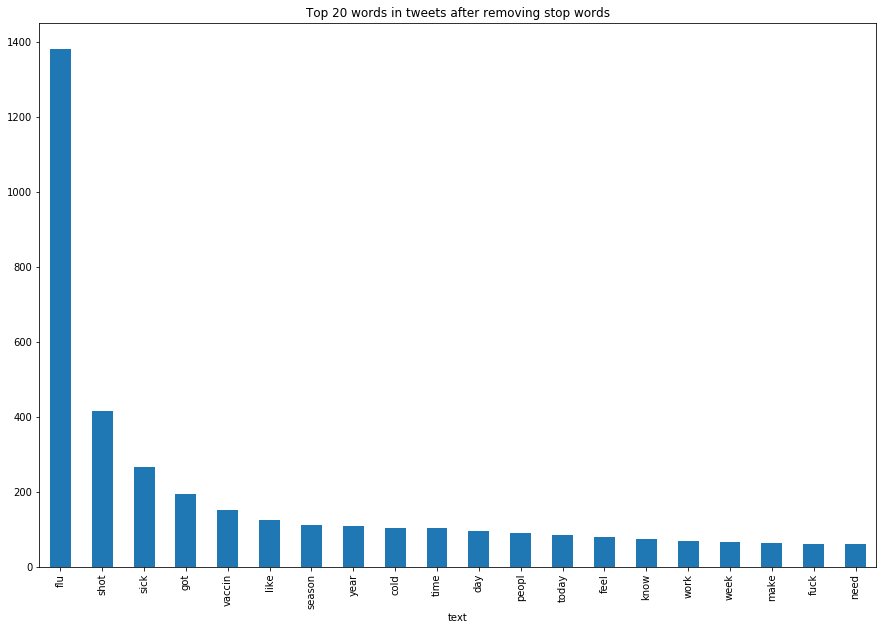

In [32]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(new['document'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
plt.figure(figsize=(15,10))
df2.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in tweets after removing stop words')
plt.show()

flu shot 394
get flu 207
got flu 103
flu season 81
flu vaccin 79
cold flu 50
flu jab 38
stomach flu 31
get sick 25
feel like 25
swine flu 20
get vaccin 19
like flu 18
give flu 17
free flu 17
catch flu 14
amp flu 14
sick flu 14
shot today 13
make sure 13


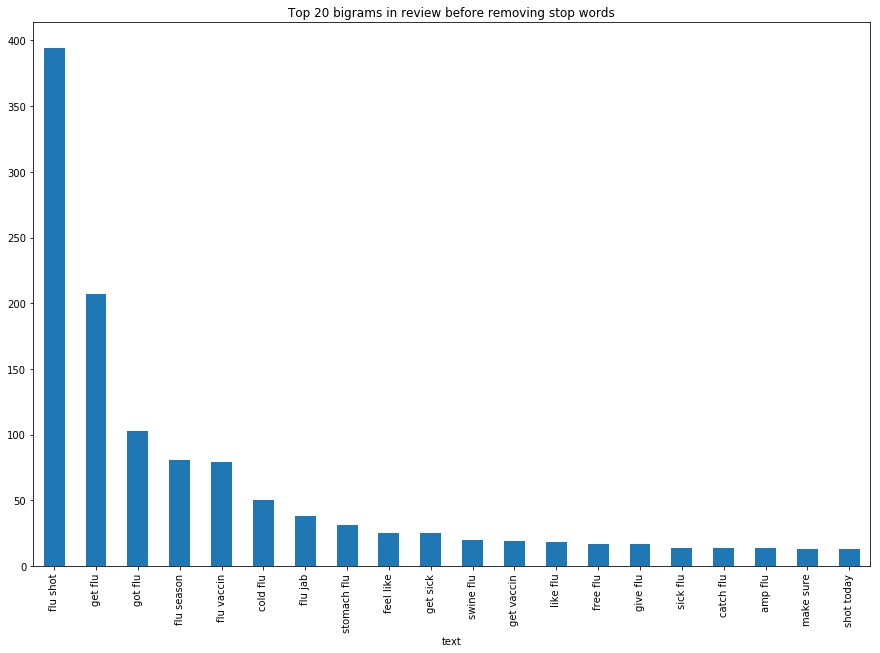

In [33]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(new['document'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
plt.figure(figsize=(15,10))
df3.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams in review before removing stop words')
plt.show()

got flu shot 58
flu shot today 15
cold flu season 14
fri chicken flu 11
flu shot clinic 11
cold amp flu 11
flu shot flu 10
flu shot protect 9
flu shot year 9
instead flu shot 8
year flu shot 7
free flu shot 7
flu vaccin today 7
gotten flu shot 6
flu shot time 6
free flu jab 6
flu flu shot 5
went flu shot 5
feel better soon 5
year flu season 5


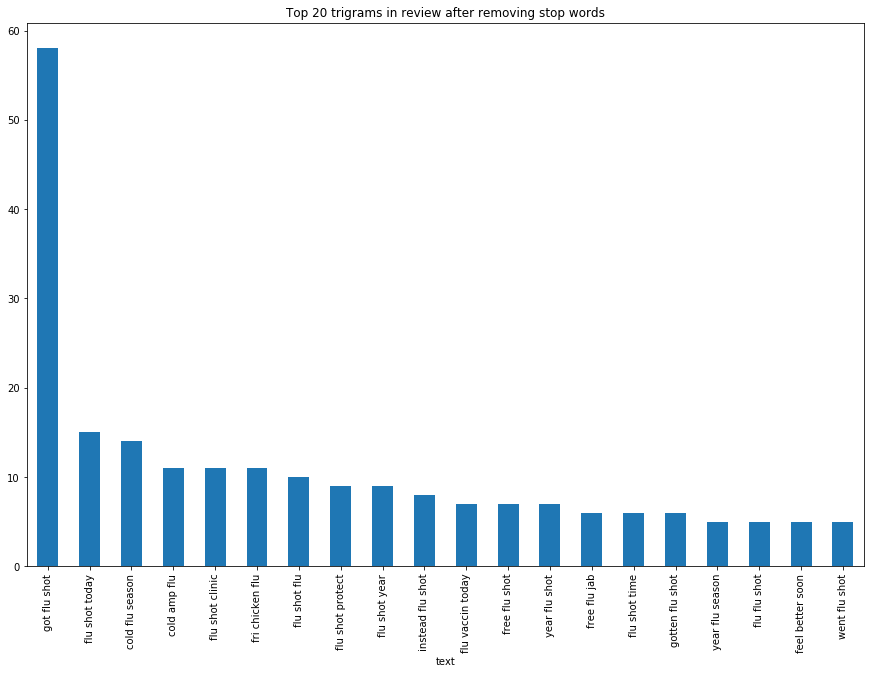

In [34]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(new['document'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
plt.figure(figsize=(15,10))
df4.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams in review after removing stop words')
plt.show()

# Defining our bag of words

### Using bag of words with our unique list of words and trying out lemmatized ,stemmed documents. Let's see which ones will get better scores. 

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(list_unique)
#remember that our 'document is from stemmed tweets with frequent words removed'
count_vector=cv.fit_transform(new['document'])
count_vectordf= pd.DataFrame(count_vector.toarray())
count_vectordf.columns= cv.get_feature_names()

In [36]:
print (count_vectordf[:10])

   abl  absolut  ach  act  activ  actual  admit  adult  african  age  ...  ye  \
0    0        0    0    0      0       0      0      0        0    0  ...   0   
1    0        0    0    0      0       0      0      0        0    0  ...   0   
2    0        0    0    0      0       0      0      0        0    0  ...   0   
3    0        0    0    0      0       1      0      0        0    0  ...   0   
4    0        0    0    0      0       0      0      0        0    0  ...   0   
5    0        0    0    0      0       0      0      0        0    0  ...   0   
6    0        0    0    0      0       0      0      0        0    0  ...   0   
7    0        0    0    0      0       0      0      0        0    0  ...   0   
8    0        0    0    0      0       0      0      0        0    0  ...   0   
9    0        0    0    0      0       0      0      0        0    0  ...   0   

   yeah  year  yesterday  yet  young  younger  your  youv  zero  
0     0     0          0    0      0      

# Logistic Regression with BOW



In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(count_vectordf, new['label'], test_size=0.20, random_state=42)

In [38]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
logreg=lr.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
predicted = (cross_val_score(LogisticRegression(solver= 'lbfgs'), X_train, y_train, cv=10))
print (predicted)

[0.8597561  0.85276074 0.87116564 0.86503067 0.82822086 0.85889571
 0.81595092 0.86419753 0.83333333 0.82716049]


              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       346
         1.0       0.65      0.35      0.46        62

    accuracy                           0.87       408
   macro avg       0.77      0.66      0.69       408
weighted avg       0.86      0.87      0.86       408

Accuracy: 0.8725490196078431


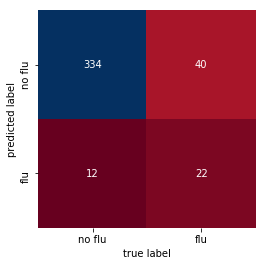

In [40]:
y_pred= logreg.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

# Naive Bayes with BOW

In [41]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

In [42]:
predicted = (cross_val_score(naive_bayes, X_train, y_train, cv=10))
print (predicted)

[0.82926829 0.84662577 0.85276074 0.77300613 0.80368098 0.7791411
 0.80368098 0.7962963  0.7962963  0.82098765]


              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89       346
         1.0       0.34      0.26      0.29        62

    accuracy                           0.81       408
   macro avg       0.61      0.58      0.59       408
weighted avg       0.79      0.81      0.80       408

Accuracy: 0.8112745098039216


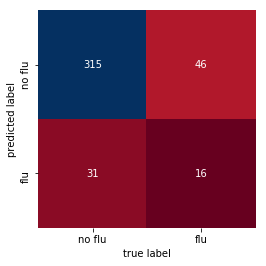

In [43]:
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])

plt.xlabel('true label')
plt.ylabel('predicted label');

## Logistic Regression with BOW Lemma

In [44]:
cv=CountVectorizer(list_unique)
count_vector=cv.fit_transform(new['document_lemma'])
count_vectordf= pd.DataFrame(count_vector.toarray())
count_vectordf.columns= cv.get_feature_names()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(count_vectordf, new['label'], test_size=0.20, random_state=42)
lr=LogisticRegression()
logreg=lr.fit(X_train, y_train)
predicted = (cross_val_score(LogisticRegression(solver= 'lbfgs'), X_train, y_train, cv=10))
print (predicted)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.8597561  0.85276074 0.86503067 0.85889571 0.82208589 0.86503067
 0.81595092 0.87037037 0.83950617 0.85802469]


              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       346
         1.0       0.56      0.29      0.38        62

    accuracy                           0.86       408
   macro avg       0.72      0.62      0.65       408
weighted avg       0.83      0.86      0.84       408

Accuracy: 0.8578431372549019


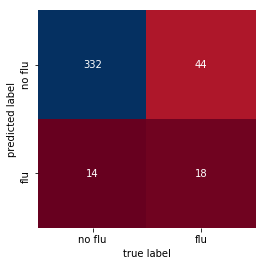

In [46]:
y_pred= lr.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

# Naive Bayes with BOW Lemma

In [47]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

In [48]:
predicted = (cross_val_score(naive_bayes, X_train, y_train, cv=10))
print (predicted)

[0.73780488 0.7791411  0.78527607 0.80368098 0.76687117 0.7607362
 0.74233129 0.79012346 0.74691358 0.77160494]


              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       346
         1.0       0.27      0.24      0.25        62

    accuracy                           0.78       408
   macro avg       0.57      0.56      0.56       408
weighted avg       0.78      0.78      0.78       408

Accuracy: 0.7843137254901961


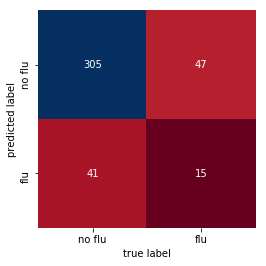

In [49]:
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])

plt.xlabel('true label')
plt.ylabel('predicted label');

# Using TF-IDF

In [50]:

X_train, X_test, y_train, y_test = train_test_split(new['document'], 
                                                    new['label'], 
                                                    test_size=0.25, 
                                                    random_state=0)

In [51]:
# Split original into train and test, used to look at text later
from sklearn.feature_extraction import text
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", 'pron']
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

#creating our Tf_idf vectorizer
vectorizer_tfidf = TfidfVectorizer(list_unique,
    max_features= 2000, # drop words that occur in more than this % of paragraphs
                             #min_df=1# only use words that appear at least 10 times
                             stop_words=stop_words, 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


# Fit and transform training data set, only transform test
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print("Number of features: %d" % X_train_tfidf.get_shape()[1])

Number of features: 705


# Logistic Regression with TF-IDF

In [52]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()

logreg=lr.fit(X_train_tfidf, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
print('Training set score:', lr.score(X_train_tfidf, y_train))

Training set score: 0.8533071381794368


In [54]:
predicted = (cross_val_score(LogisticRegression(), X_train_tfidf, y_train, cv=10))
print (predicted)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.83766234 0.79738562 0.83006536 0.83006536 0.83660131 0.84313725
 0.84868421 0.84210526 0.84210526 0.84210526]


              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       426
         1.0       0.67      0.02      0.05        83

    accuracy                           0.84       509
   macro avg       0.75      0.51      0.48       509
weighted avg       0.81      0.84      0.77       509

Accuracy: 0.8388998035363457


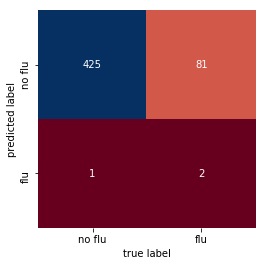

In [55]:
y_pred= logreg.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])

plt.xlabel('true label')
plt.ylabel('predicted label');

# Naive Bayes with TF-IDF

In [56]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tfidf, y_train)
print('Training set score:', naive_bayes.score(X_train_tfidf, y_train))

Training set score: 0.8519973804846104


In [57]:
predicted = (cross_val_score(MultinomialNB(), X_train_tfidf, y_train, cv=10))
print (predicted)

[0.83116883 0.83660131 0.83006536 0.83660131 0.84313725 0.84313725
 0.84210526 0.84210526 0.84868421 0.84868421]


              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       426
         1.0       0.00      0.00      0.00        83

    accuracy                           0.83       509
   macro avg       0.42      0.50      0.46       509
weighted avg       0.70      0.83      0.76       509

Accuracy: 0.8349705304518664


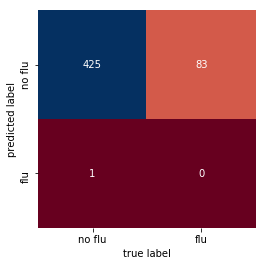

In [58]:
y_pred= naive_bayes.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])

plt.xlabel('true label')
plt.ylabel('predicted label');

# So far, Logistic Regression with BOW has the highest score when used with stemmed words and unique set of words. But what about bigrams and trigrams? Will this produce better scores than BOW? 

### Logistic Regression with Bigrams

In [59]:
# Using bigrams 
cv=CountVectorizer(list_unique, ngram_range=(2, 2))
count_vector= cv.fit_transform(new['document'])
count_vectordf= pd.DataFrame(count_vector.toarray())
count_vectordf.columns= cv.get_feature_names()

In [60]:
X= count_vectordf
X_train, X_test, y_train, y_test = train_test_split(X, new['label'], test_size=0.20, random_state=42)

In [61]:
lr=LogisticRegression()

logreg=lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.9459459459459459


In [62]:
predicted = (cross_val_score(LogisticRegression(solver= 'lbfgs'), X_train, y_train, cv=10))
print (predicted)

[0.84756098 0.83435583 0.82208589 0.8404908  0.82208589 0.8404908
 0.8404908  0.84567901 0.82716049 0.85802469]


In [63]:
y_pred= logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92       346
         1.0       0.54      0.11      0.19        62

    accuracy                           0.85       408
   macro avg       0.70      0.55      0.55       408
weighted avg       0.81      0.85      0.81       408

Accuracy: 0.8504901960784313


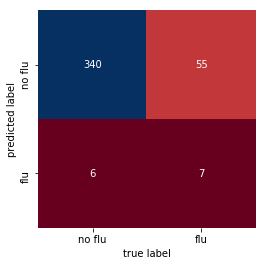

In [64]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Naive Bayes with Bigrams

In [65]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
print('Training set score:', naive_bayes.score(X_train, y_train))

Training set score: 0.9606879606879607


In [66]:
predicted = (cross_val_score(MultinomialNB(), X_train, y_train, cv=10))
print (predicted)

[0.73780488 0.69325153 0.74233129 0.6809816  0.72392638 0.70552147
 0.72392638 0.70987654 0.67283951 0.77160494]


              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83       346
         1.0       0.28      0.52      0.37        62

    accuracy                           0.73       408
   macro avg       0.59      0.64      0.60       408
weighted avg       0.80      0.73      0.76       408

Accuracy: 0.7279411764705882


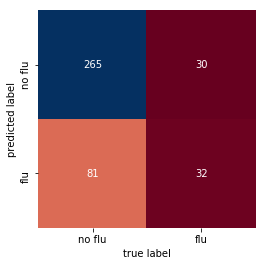

In [67]:
y_pred= naive_bayes.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])

plt.xlabel('true label')
plt.ylabel('predicted label');

### Logistic Regression with Trigrams

In [68]:
#Trigrams
cv=CountVectorizer(ngram_range=(3, 3))
count_vector= cv.fit_transform(new['document'])
count_vectordf= pd.DataFrame(count_vector.toarray())
count_vectordf.columns= cv.get_feature_names()
X= count_vectordf
X_train, X_test, y_train, y_test = train_test_split(X, new['label'], test_size=0.20, random_state=42)

In [69]:
lr=LogisticRegression()

logreg=lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.9164619164619164


In [70]:
predicted = (cross_val_score(LogisticRegression(solver= 'lbfgs'), X_train, y_train, cv=10))
print (predicted)

[0.82926829 0.83435583 0.83435583 0.82822086 0.82208589 0.83435583
 0.83435583 0.83950617 0.83333333 0.84567901]


              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91       346
         1.0       0.33      0.03      0.06        62

    accuracy                           0.84       408
   macro avg       0.59      0.51      0.49       408
weighted avg       0.77      0.84      0.78       408

Accuracy: 0.8431372549019608


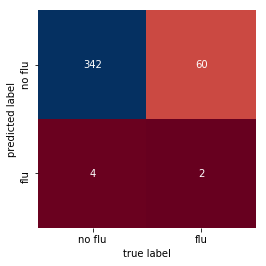

In [71]:
y_pred= logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [72]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
print('Training set score:', naive_bayes.score(X_train, y_train))

Training set score: 0.957002457002457


In [73]:
predicted = (cross_val_score(MultinomialNB(), X_train, y_train, cv=10))
print (predicted)

[0.65243902 0.6196319  0.63803681 0.60122699 0.67484663 0.63190184
 0.65644172 0.61111111 0.57407407 0.60493827]


              precision    recall  f1-score   support

         0.0       0.90      0.61      0.73       346
         1.0       0.22      0.63      0.33        62

    accuracy                           0.61       408
   macro avg       0.56      0.62      0.53       408
weighted avg       0.80      0.61      0.67       408

Accuracy: 0.6127450980392157


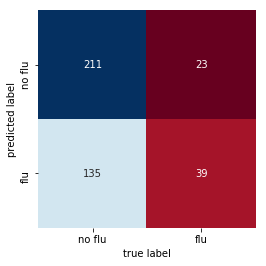

In [74]:
y_pred= naive_bayes.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap= 'RdBu', cbar=False,
            xticklabels=['no flu', 'flu'], yticklabels=['no flu', 'flu'])

plt.xlabel('true label')
plt.ylabel('predicted label');

# With the same data, we train a BERT classifier in the next notebook. There will be two notebooks, one without tuning, and another with tuning. We can then compare the scores of our classifiers in the end. 